In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

import os

from matplotlib import pyplot as plt

from tqdm import tqdm
from PIL import Image as Img
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop

In [ ]:

# Update the path to your image directory on Google Drive
PIC_DIR = '/content/drive/My Drive/CIP/Datasets/Celebrity_Face/'

IMAGES_COUNT = 10000
ORIG_WIDTH = 178
ORIG_HEIGHT = 218
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2
WIDTH = 128
HEIGHT = 128
crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

In [ ]:


images = []

# Iterate over the first IMAGES_COUNT images in the directory
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    # Construct the full path to each image
    pic_path = os.path.join(PIC_DIR, pic_file)
    # Open the image
    pic = Img.open(pic_path).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Img.ANTIALIAS)
    images.append(np.uint8(pic))

# Now 'images' contains the preprocessed images imported from Google Drive

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-4-535b528bd760>:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pic.thumbnail((WIDTH, HEIGHT), Img.ANTIALIAS)
100%|██████████| 10000/10000 [03:38<00:00, 45.73it/s]


In [ ]:
#Image shape
images = np.array(images) / 255
print(images.shape)

(10000, 128, 128, 3)


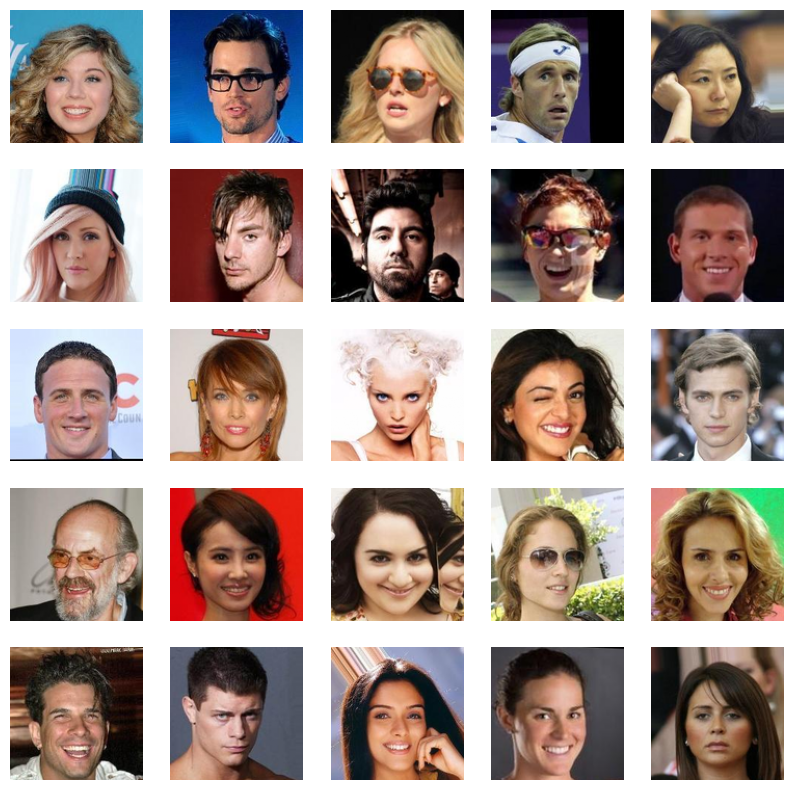

In [ ]:
#Display first 25 images
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [ ]:
LATENT_DIM = 32
CHANNELS = 3

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

In [ ]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = tf.keras.optimizers.legacy.RMSprop(
        learning_rate=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

In [ ]:
generator = create_generator()
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 256)       104883

In [ ]:
discriminator = create_discriminator()
discriminator.trainable = False
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 256)     7168      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 126, 126, 256)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 256)       1048832   
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 62, 62, 256)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       1048832   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 30, 30, 256)       0   

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Plot the model architecture
plt.figure(figsize=(10, 6))
plt.title("Model Architecture")
# Import the plot_model function from tensorflow.keras.utils to convert the model into a graph
from tf.keras.utils import plot_model
# Plot the model graph
plot_model(generator, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# Show the plot
img = plt.imread('model_plot.png')
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

In [ ]:
optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [ ]:
gan.summary()

In [ ]:
import time

iters = 15000
batch_size = 16

# Update paths to use Google Drive
RES_DIR = '/content/drive/My Drive/CIP/GAN_2/Outputs/'
FILE_PATH = '%s/generated_%d.png'

# Create the directory if it doesn't exist
if not os.path.isdir(RES_DIR):
    os.makedirs(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    print("Epoch",step)
    start_time = time.time()
    print("Generating random Noises")
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    print("Generator predicting noises")
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    print("Training Discriminator")
    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    print("Training GAN")
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        print("Saving Weights")
        gan.save_weights('/content/drive/My Drive/CIP/GAN_2/Weights/gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)

        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Img.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1


In [ ]:
#Continue training code
# Update paths to use Google Drive
import time

iters = 1500
batch_size = 16

RES_DIR = '/content/drive/My Drive/CIP/GAN_2/Outputs/'
FILE_PATH = '%s/generated_%d.png'
WEIGHTS_PATH = '/content/drive/My Drive/CIP/GAN_2/Weights/gan.h5'

# Create the directory if it doesn't exist
if not os.path.isdir(RES_DIR):
    os.makedirs(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

# Load weights of the GAN (which includes both generator and discriminator)
gan.load_weights(WEIGHTS_PATH)

start = 0
d_losses = []
a_losses = []
images_saved = 43

for step in range(iters):
    print("Epoch", step)
    start_time = time.time()
    #print("Generating random Noises")
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    #print("Generator predicting noises")
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    #print("Training Discriminator")
    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    #print("Training GAN")
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        #print("Saving Weights")
        gan.save_weights(WEIGHTS_PATH)

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (
        step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)

        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT,
            :] = control_generated[i, :, :, :]
        im = Img.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1


Epoch 0
1/1 [==============================] - 38s 38s/step
Epoch 1
1/1 [==============================] - 0s 18ms/step
Epoch 2
1/1 [==============================] - 0s 19ms/step
Epoch 3
1/1 [==============================] - 0s 27ms/step
Epoch 4
1/1 [==============================] - 0s 18ms/step
Epoch 5
1/1 [==============================] - 0s 18ms/step
Epoch 6
1/1 [==============================] - 0s 18ms/step
Epoch 7
1/1 [==============================] - 0s 28ms/step
Epoch 8
1/1 [==============================] - 0s 18ms/step
Epoch 9
1/1 [==============================] - 0s 18ms/step
Epoch 10
1/1 [==============================] - 0s 18ms/step
Epoch 11
1/1 [==============================] - 0s 19ms/step
Epoch 12
1/1 [==============================] - 0s 20ms/step
Epoch 13
1/1 [==============================] - 0s 20ms/step
Epoch 14
1/1 [==============================] - 0s 26ms/step
Epoch 15
1/1 [==============================] - 0s 17ms/step
Epoch 16
1/1 [====================

KeyboardInterrupt: 

In [ ]:
#image generation after training
# Update paths to use Google Drive
RES_DIR = '/content/drive/My Drive/CIP/GAN_2/Generated_images/'
FILE_PATH = '%s/generated_%d.png'
WEIGHTS_PATH = '/content/drive/My Drive/CIP/GAN_2/Weights/gan.h5'

# Create the directory if it doesn't exist
if not os.path.isdir(RES_DIR):
    os.makedirs(RES_DIR)

# Load weights of the GAN (which includes the generator)
gan.load_weights(WEIGHTS_PATH)

# Number of images to generate
num_images = 10  # Adjust as needed

# Generate random latent vectors
latent_vectors = np.random.normal(size=(num_images, LATENT_DIM))

# Generate images using the generator part of the GAN
generated_images = generator.predict(latent_vectors)

# Save generated images
for i in range(num_images):
    img = Img.fromarray(np.uint8(generated_images[i] * 255))
    img.save(FILE_PATH % (RES_DIR, i))

print("Generated and saved", num_images, "images.")


1/1 [==============================] - 44s 44s/step
Generated and saved 10 images.
